# HOG

In [1]:
import cv2
import os
import numpy as np
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def get_hog(img, pix_per_cell = 8, cell_per_block = 2, orient = 9,vis=True):
    features, hog_image = hog(img, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=True, feature_vector=False,
                              block_norm="L2-Hys")
    return features, hog_image

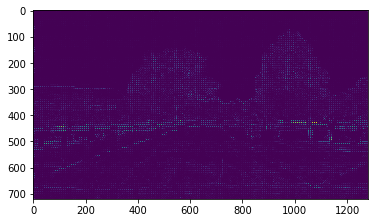

In [90]:
test_image1 = cv2.imread('test_images/test1.jpg')
test_image1 = cv2.cvtColor( test_image1, cv2.COLOR_RGB2GRAY )
features, hog_image = get_hog(test_image1)
plt.imshow(hog_image)

In [4]:
def get_sliding_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.5)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [154]:
def apply_to_windows(img, bboxes, X_scaler):
    true_boxes = []
    for top_left, bottom_right in bboxes:
        pix_per_cell = int((bottom_right[0] - top_left[0])/8)
        ch1 = img[:,:,0]
        ch2 = img[:,:,1]
        ch3 = img[:,:,2]
        features1, _ = get_hog(ch1[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]], pix_per_cell=pix_per_cell)
        features2, _ = get_hog(ch2[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]], pix_per_cell=pix_per_cell)
        features3, _ = get_hog(ch3[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]], pix_per_cell=pix_per_cell)
        features = np.vstack((features1,features2, features3)).reshape(1,-1)
        features = X_scaler.transform(features)
        pred = svc.predict(features)
        if pred[0]:
            true_boxes.append([top_left, bottom_right])
    return true_boxes
        

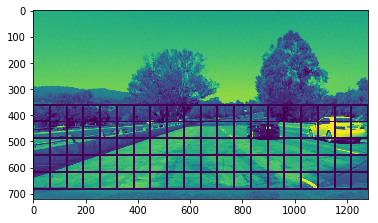

In [38]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

imcopy = np.copy(test_image1)
for scale in [128]:
    bboxes = get_sliding_windows(imcopy, xy_window=(scale, scale))
    imcopy = draw_boxes(imcopy, bboxes)
    
plt.figure()
plt.imshow(imcopy)

In [35]:
for scale in [64,128,256]:
    bboxes = get_sliding_windows(test_image1, xy_window=(scale, scale))
    all_features,all_hog_images =  apply_to_windows(test_image1, bboxes)

In [8]:
all_features[0].shape

(1764,)

In [9]:
pos_data_path = 'vehicles/GTI/'
neg_data_path = 'non-vehicles/GTI/'

num_data_per_class = min(len(os.listdir(pos_data_path)), len(os.listdir(neg_data_path)))
num_data_per_class

2826

In [145]:

X_feats = []
count = 0
for filename in os.listdir(pos_data_path):
    if count >= num_data_per_class:
        break
    if filename == '.DS_Store':
        continue
        
    full_filename = os.path.join(pos_data_path, filename)
    img = cv2.imread(full_filename)
    try:
        img = cv2.cvtColor( img, cv2.COLOR_RGB2YCrCb )
    except:
        print(full_filename, img==None)

    pix_per_cell = img.shape[0]/8
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    features1, _ = get_hog(ch1, pix_per_cell=pix_per_cell)
    features2, _ = get_hog(ch2, pix_per_cell=pix_per_cell)
    features3, _ = get_hog(ch3, pix_per_cell=pix_per_cell)
    features = np.vstack((features1,features2, features3)).reshape(-1)
    X_feats.append(features)
    count+=1

count = 0
for filename in os.listdir(neg_data_path):
    if count >= num_data_per_class:
        break
    if filename == '.DS_Store':
        continue
        
    full_filename = os.path.join(neg_data_path, filename)
    img = cv2.imread(full_filename)
    try:
        img = cv2.cvtColor( img, cv2.COLOR_RGB2YCrCb )
    except:
        print(full_filename, img==None)

    pix_per_cell = img.shape[0]/8
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    features1, _ = get_hog(ch1, pix_per_cell=pix_per_cell)
    features2, _ = get_hog(ch2, pix_per_cell=pix_per_cell)
    features3, _ = get_hog(ch3, pix_per_cell=pix_per_cell)
    features = np.vstack((features1,features2, features3)).reshape(-1)
    X_feats.append(features)
    count+=1

In [146]:
X = np.array(X_feats)
# Define the labels vector
y = np.hstack((np.ones(num_data_per_class), np.zeros(num_data_per_class)))

print(X.shape)
print(y.shape)

(5652, 5292)
(5652,)


In [147]:
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


In [148]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.66 Seconds to train SVC...
Test Accuracy of SVC =  0.954
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  1.  1.  1.]
0.00385 Seconds to predict 10 labels with SVC


In [62]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    hm = np.copy(heatmap)
    # Zero out pixels below the threshold
    hm[hm <= threshold] = 0
    # Return thresholded map
    return hm

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [77]:
heat = np.zeros(test_image1.shape)
for scale in [96, 128,160, 256]:
    bboxes = get_sliding_windows(test_image1, xy_window=(scale, scale))
    bboxes = np.array(bboxes)
    bboxes =apply_to_windows(test_image1, bboxes, X_scaler)
    
    add_heat(heat, bboxes[pred==1])
    
    

9.0


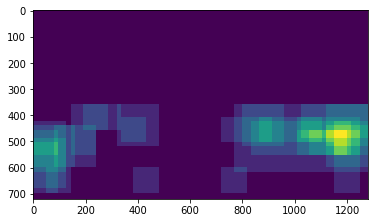

In [78]:
print(np.max(heat))
plt.imshow(heat)

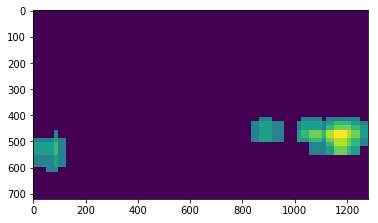

In [79]:
heat_thresh = apply_threshold(heat, 3)
plt.imshow(heat_thresh)

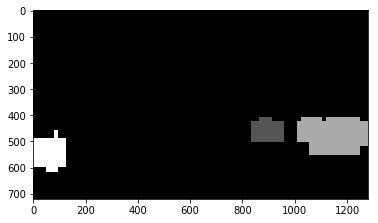

In [93]:
from scipy.ndimage.measurements import label
labels = label(heat_thresh)
plt.imshow(labels[0], cmap='gray')

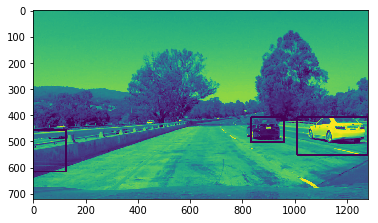

In [94]:

plt.imshow(draw_labeled_bboxes(np.copy(test_image1), labels))

In [185]:
from scipy.ndimage.measurements import label

previous = [None]*6
def pipeline(color_img, index, X_scaler):
    global previous
    img = cv2.cvtColor( color_img, cv2.COLOR_RGB2YCrCb) 
    heat = np.zeros(img.shape)
    for scale in [64, 96, 128,160]:
        bboxes = get_sliding_windows(img, xy_window=(scale, scale))
        bboxes = np.array(bboxes)
        bb =  apply_to_windows(img, bboxes, X_scaler)
        #all_features = np.array(X_scaler.transform(all_features))
        #pred = svc.predict(all_features)
        #bb = bboxes[pred==1]
        add_heat(heat,bb)
        heat = apply_threshold(heat, 1)
        
    scale = 255.0/ np.max(heat)
    
    for prev in previous:
        if prev is not None:
            add_heat(heat, prev)
            heat = apply_threshold(heat, 2)
    
    print(np.max(heat))
    heat_thresh = apply_threshold(heat, 10)
    previous = previous[1:]
    previous.append(bb)
    
    scale = 255.0/ np.max(heat)

    labels = label(heat_thresh)
    bbox_frame = draw_labeled_bboxes(np.copy(color_img), labels)
    
    return bbox_frame

In [186]:
video = None
cap = cv2.VideoCapture('project_video.mp4')

index = 0
ret = True
while(ret):
    ret, frame = cap.read()
    index += 1
    #if index < 500:
    #    continue
    #if index >= 520:
    #    break
    if ret :
        frame_out = pipeline(frame, index, X_scaler)
        h,w,c = frame_out.shape
        if video is None:
            video = cv2.VideoWriter('project_video_solved6.avi',-1,20,(w,h))
            
        video.write(frame_out)
    
video.release()
cap.release()

7.0
7.0
6.0
8.0
10.0
14.0
15.0
16.0
10.0
16.0
15.0
14.0
12.0
11.0
8.0
5.0
9.0
7.0
7.0
6.0
8.0
10.0
10.0
10.0
9.0
11.0
13.0
11.0
12.0
11.0
8.0
10.0
10.0
9.0
9.0
8.0
8.0
10.0
10.0
11.0
10.0
9.0
11.0
10.0
9.0
8.0
9.0
7.0
6.0
5.0
8.0
7.0
10.0
10.0
10.0
8.0
8.0
10.0
12.0
12.0
4.0
10.0
13.0
10.0
12.0
9.0
9.0
12.0
14.0
12.0
11.0
11.0
9.0
9.0
7.0
8.0
7.0
9.0
8.0
11.0
12.0
12.0
11.0
11.0
10.0
11.0
10.0
10.0
14.0
9.0
11.0
12.0
9.0
9.0
9.0
12.0
11.0
10.0
11.0
13.0
12.0
10.0
9.0
10.0
7.0
9.0
8.0
7.0
11.0
9.0
6.0
7.0
4.0
6.0
7.0
4.0
4.0
5.0
5.0
4.0
4.0
7.0
6.0
7.0
7.0
12.0
11.0
9.0
7.0
9.0
9.0
11.0
10.0
7.0
6.0
6.0
5.0
7.0
5.0
5.0
6.0
7.0
6.0
6.0
8.0
8.0
7.0
5.0
5.0
7.0
7.0
6.0
5.0
6.0
5.0
5.0
6.0
5.0
8.0
7.0
9.0
9.0
10.0
10.0
15.0
17.0
16.0
17.0
16.0
13.0
14.0
12.0
11.0
11.0
12.0
12.0
13.0
12.0
10.0
10.0
10.0
11.0
12.0
14.0
14.0
13.0
11.0
13.0
12.0
10.0
8.0
9.0
9.0
10.0
11.0
11.0
9.0
11.0
9.0
12.0
13.0
14.0
14.0
14.0
13.0
15.0
15.0
16.0
16.0
12.0
18.0
18.0
18.0
20.0
22.0
19.0
20.0
21.0
21.0
20.0
1

KeyboardInterrupt: 

In [187]:
video.release()
